In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import scvi

In [2]:
adata = sc.read_h5ad("../data/emt.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 5027 × 2000
    obs: 'cell', 'total_umis', 'sample', 'TSNE.1', 'TSNE.2', 'Size_Factor', 'treatment_id', 'spatial_id', 'cell_type', 'dpt_pseudotime'
    var: 'id', 'gene_short_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'cell_type_colors', 'diffmap_evals', 'hvg', 'iroot', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


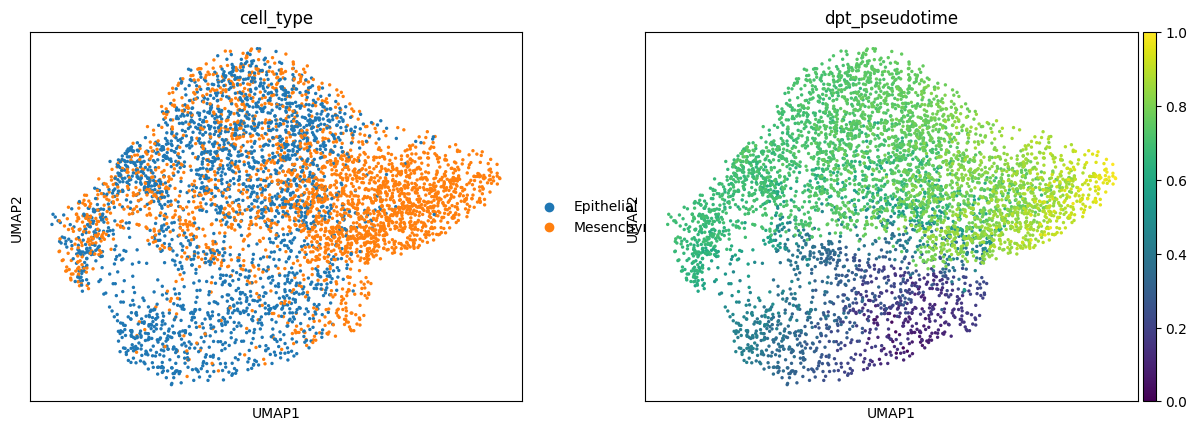

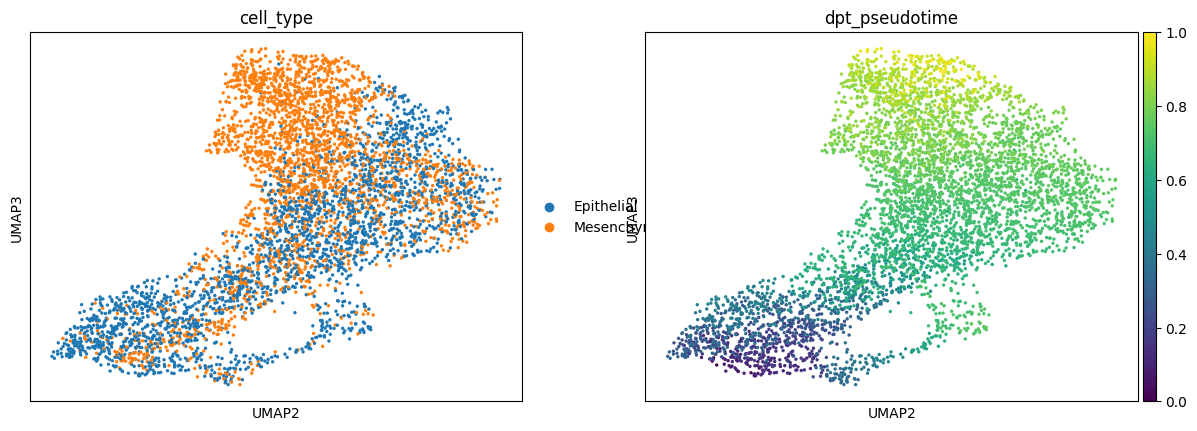

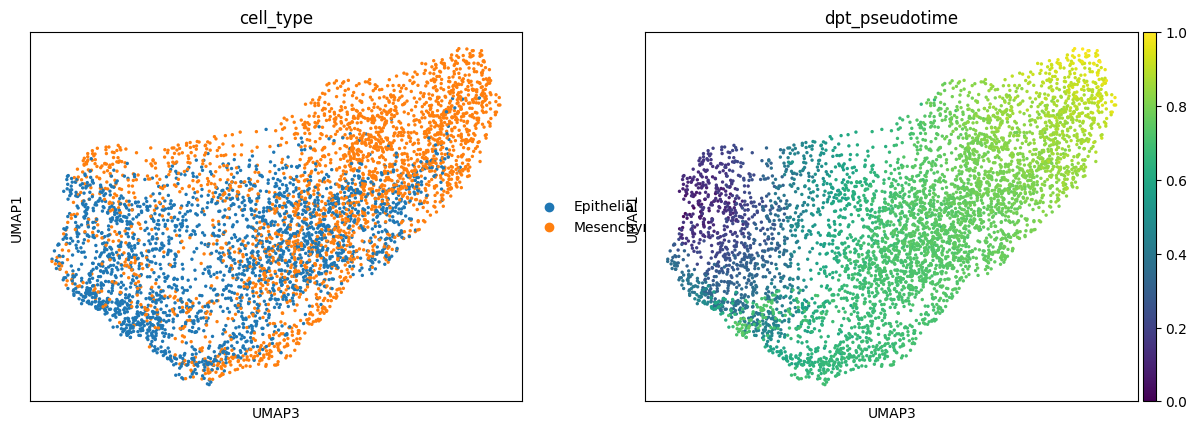

In [4]:
plot_umap(adata, ['cell_type', 'dpt_pseudotime'])

In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer=None,            
)

model = scvi.model.SCVI(adata, n_latent=512, n_layers=4, n_hidden=1024)   
model.train() 


/mnt/home/islamsa3/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/islamsa3/.local/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/islamsa3/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/islamsa3/.local/lib/python3.10/site-packag ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utili

Training:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:93: UserWarning: No PYTORCH_KERNEL_CACHE_PATH or HOME environment variable set! This disables kernel caching. (Triggered internally at ../aten/src/ATen/native/cuda/jit_utils.cpp:1426.)
  + lgamma(x + theta)
`Trainer.fit` stopped: `max_epochs=400` reached.


In [6]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [7]:
z_E = adata.obsm['X_scVI'][0]
z_M = adata.obsm['X_scVI'][-1]
X_latent = adata.obsm["X_scVI"] 

In [8]:
Z_interp = interpolate(z_E, z_M, 200)
Z_interp = [tensor.numpy().squeeze() for tensor in Z_interp]
Z_interp = np.stack(Z_interp, axis=0)
Z_interp = Z_interp[::-1, :]

In [9]:
X_expr = adata.X
if not isinstance(X_expr, np.ndarray):
    X_expr = X_expr.todense() 
X_expr = X_expr.astype(np.float32)                               

n_cells, latent_dim = X_latent.shape
_, n_genes = X_expr.shape
print(latent_dim, n_genes)

512 2000


In [10]:
idx = np.arange(n_cells)
np.random.shuffle(idx)
split = int(0.8 * n_cells)
train_idx, val_idx = idx[:split], idx[split:]

train_ds = LatentToExprDataset(X_latent[train_idx], X_expr[train_idx])
val_ds   = LatentToExprDataset(X_latent[val_idx],   X_expr[val_idx])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

decoder = LatentToGeneMLP(
    latent_dim=latent_dim,
    hidden_dim=1024,
    n_genes=n_genes
).to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

In [12]:
n_epochs = 1000

for epoch in range(n_epochs):
    decoder.train()
    train_loss = 0.0

    for z_batch, x_batch in train_loader:
        z_batch = z_batch.to(device)
        x_batch = x_batch.to(device)

        optimizer.zero_grad()
        x_pred = decoder(z_batch)
        loss = criterion(x_pred, x_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * z_batch.size(0)

    train_loss /= len(train_ds)

    # validation
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for z_batch, x_batch in val_loader:
            z_batch = z_batch.to(device)
            x_batch = x_batch.to(device)
            x_pred = decoder(z_batch)
            loss = criterion(x_pred, x_batch)
            val_loss += loss.item() * z_batch.size(0)
    val_loss /= len(val_ds)

    print(f"Epoch {epoch+1:02d} | train MSE: {train_loss:.4f} | val MSE: {val_loss:.4f}")


Epoch 01 | train MSE: 41.6766 | val MSE: 30.4664
Epoch 02 | train MSE: 23.4043 | val MSE: 19.0524
Epoch 03 | train MSE: 17.2849 | val MSE: 16.5450
Epoch 04 | train MSE: 15.1463 | val MSE: 14.1266
Epoch 05 | train MSE: 12.6170 | val MSE: 11.5921
Epoch 06 | train MSE: 10.8333 | val MSE: 10.3206
Epoch 07 | train MSE: 9.9196 | val MSE: 9.6642
Epoch 08 | train MSE: 9.3587 | val MSE: 9.1997
Epoch 09 | train MSE: 8.8930 | val MSE: 8.7894
Epoch 10 | train MSE: 8.5288 | val MSE: 8.4630
Epoch 11 | train MSE: 8.1613 | val MSE: 8.1990
Epoch 12 | train MSE: 7.8964 | val MSE: 7.9314
Epoch 13 | train MSE: 7.6432 | val MSE: 7.7446
Epoch 14 | train MSE: 7.4576 | val MSE: 7.5409
Epoch 15 | train MSE: 7.2785 | val MSE: 7.4139
Epoch 16 | train MSE: 7.1562 | val MSE: 7.2743
Epoch 17 | train MSE: 7.0128 | val MSE: 7.1885
Epoch 18 | train MSE: 6.9219 | val MSE: 7.0604
Epoch 19 | train MSE: 6.8004 | val MSE: 6.9686
Epoch 20 | train MSE: 6.7237 | val MSE: 6.9002
Epoch 21 | train MSE: 6.6324 | val MSE: 6.8061
E

In [13]:
decoder.eval()
with torch.no_grad():
    z_t = torch.from_numpy(Z_interp.copy()).to(device)
    X_syn = decoder(z_t).cpu().numpy()   

In [14]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [15]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [16]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


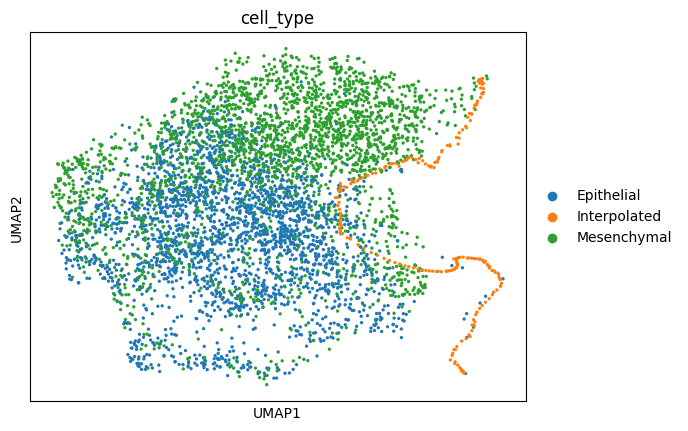

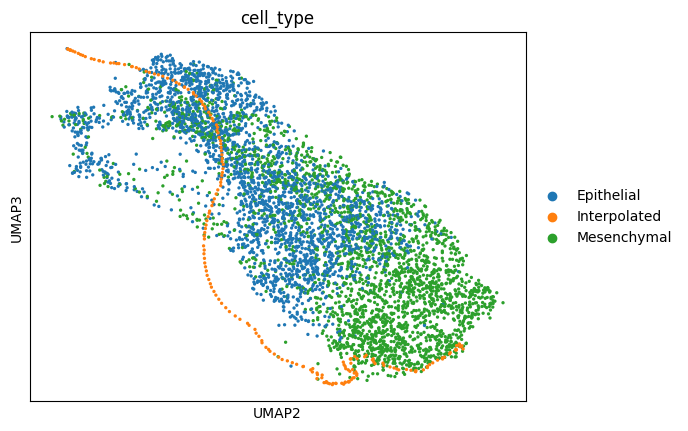

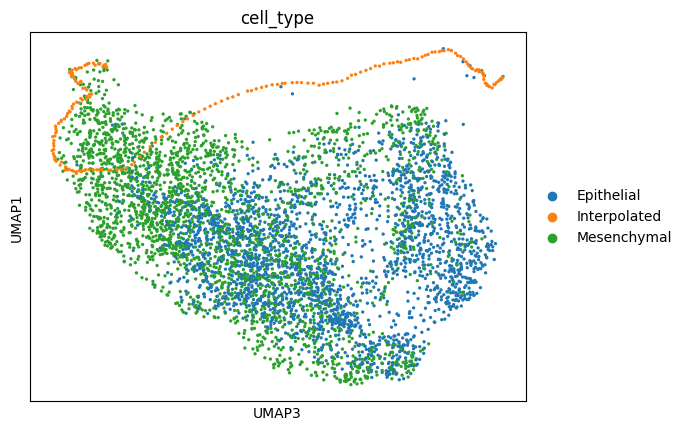

In [17]:
plot_umap(combined_adata, 'cell_type')

Available epithelial markers: ['CDH1', 'CRB3', 'DSP']
Available mesenchymal markers: ['VIM', 'FN1', 'SNAI2']


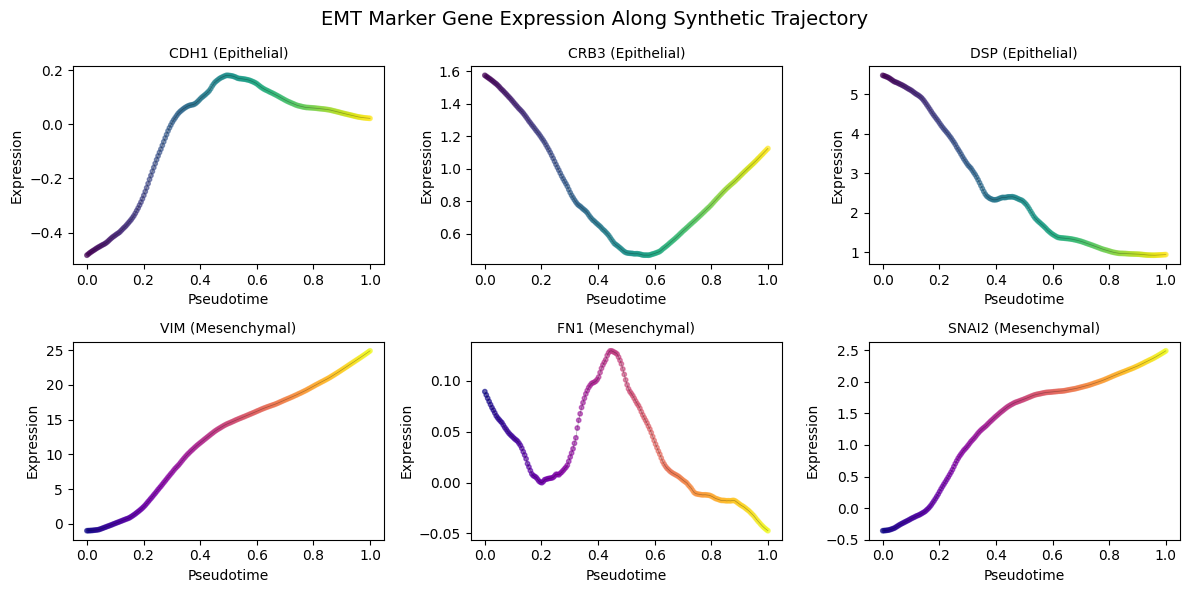

In [18]:
epithelial_markers = ['CDH1', 'CRB3', 'DSP']
mesenchymal_markers = ['VIM', 'FN1', 'SNAI2']

gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_epithelial = [g for g in epithelial_markers if g in gene_names]
available_mesenchymal = [g for g in mesenchymal_markers if g in gene_names]

print(f"Available epithelial markers: {available_epithelial}")
print(f"Available mesenchymal markers: {available_mesenchymal}")

if available_epithelial or available_mesenchymal:
    n_markers = len(available_epithelial) + len(available_mesenchymal)
    n_cols = 3
    n_rows = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,200)
    
    plot_idx = 0
    for gene in available_epithelial:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Epithelial)', fontsize=10)
        plot_idx += 1
    
    for gene in available_mesenchymal:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='plasma', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mesenchymal)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('EMT Marker Gene Expression Along Synthetic Trajectory', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No common EMT markers found in the dataset")

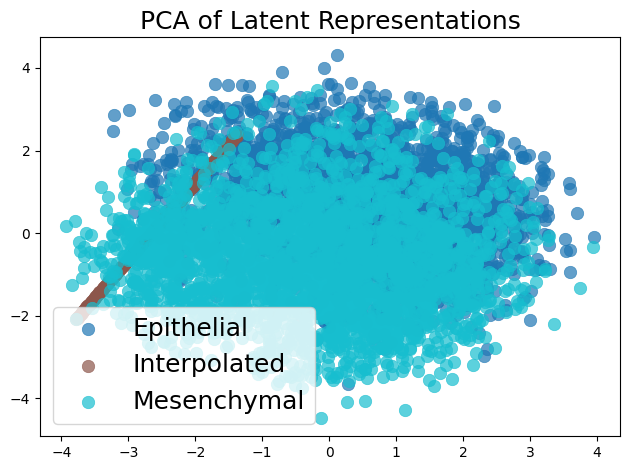

In [19]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z_interp])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}

for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


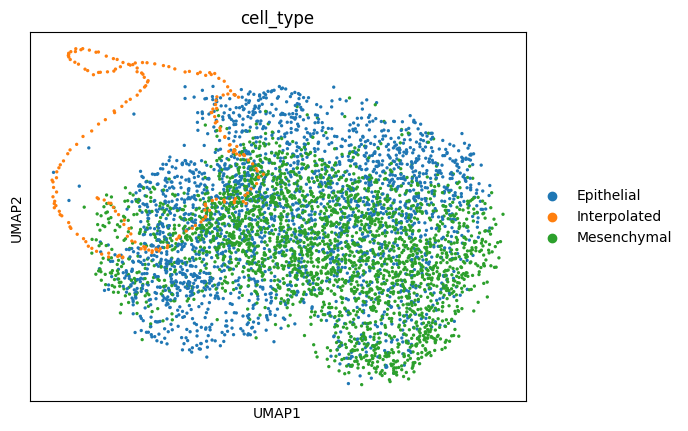

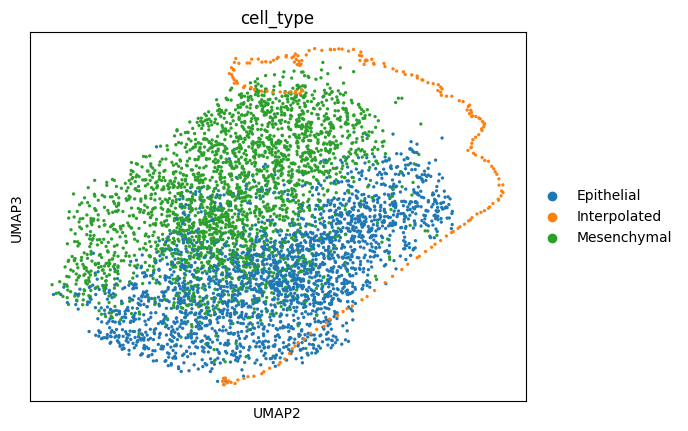

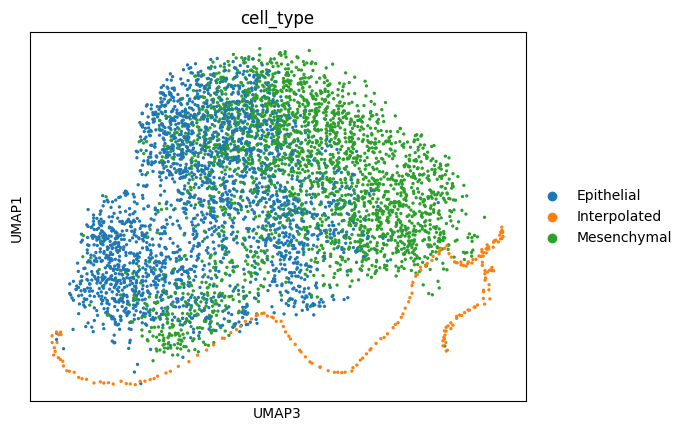

In [20]:
adata_latent_syn = anndata.AnnData(Z_interp)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [21]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, 200),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.19756886655081005, 'delta_t_median': 0.15609532355064126, 'delta_t_max': 0.4344604982802616, 'dist_mean': 122.60451244354248, 'dist_median': 98.4913558959961, 'dist_max': 221.9824676513672}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.0,0.000000,93.834923
1,0.005025,0.0,0.005025,95.013489
2,0.010050,0.0,0.010050,96.304359
3,0.015075,0.0,0.015075,97.696228
4,0.020101,0.0,0.020101,99.182884


In [22]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 122.60451244354248, 'dist_median': 98.4913558959961, 'dist_max': 221.9824676513672, 'smooth_mean_abs_delta': 1.5698997842606588, 'smooth_max_abs_delta': 5.6255645751953125}


In [23]:
marker_sets = {
    "Epithelial": ["CDH1", "CRB3", "DSP"],
    "Mesenchymal": ["VIM", "FN1", "SNAI2"],
}

expected_directions = {
    "Epithelial": -1,   
    "Mesenchymal": 1,   
}

df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, 200),      
    gene_list=list(gene_names),
    marker_sets=marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()


         group  n_genes  mean_rho  median_rho  frac_sign_ok
0   Epithelial        3 -0.311907   -0.411441      0.666667
1  Mesenchymal        3  0.457760    1.000000      0.666667


,group,gene,rho,pval,expected_dir,sign_ok
0,Epithelial,CDH1,0.472821,1.555351e-12,-1,False
1,Epithelial,CRB3,-0.411441,1.427269e-09,-1,True
2,Epithelial,DSP,-0.997100,1.840608e-223,-1,True
3,Mesenchymal,VIM,1.000000,0.000000e+00,1,True
4,Mesenchymal,FN1,-0.626719,3.193116e-23,1,False


In [24]:
adata_interpolated_cells.write_h5ad('../data/syn_emt_scvi.h5ad')